In [225]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import LeaveOneOut
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss
from sklearn.ensemble import StackingClassifier

In [163]:
df_target = pd.read_excel("Diversity_metadata.xlsx", skiprows=[1])
df_target.head()

,id,Age_group,BMI_cat,Gender,Race_cat,Ethnicity,Insurance,Income,Cancertype,Radiotherapy,...,Depression_bi,Sleepdis_level,Sleepdis_bi,Sleepim_level,Sleepim_bi,Totalnum_PNS,PNS_cat,observed_features,shannon_entropy,pielou_evenness
0,JBA13264-0001-GOAL1001C-GM1,2024-12-17 00:00:00,Normal,Male,White,Non-Hispanic,Private,>40K,Medulloblastoma,Yes,...,Yes,Mild,Yes,Mild,Yes,4,Yes,422,7.365179,0.844524
1,JBA13264-0002-GOAL1002C-GM1,2024-12-17 00:00:00,Normal,Male,Asian,Non-Hispanic,Public,<40K,Medulloblastoma,No,...,Yes,Severe,Yes,Severe,Yes,6,Yes,232,5.223793,0.664775
2,JBA13264-0003-GOAL1003C-GM1,18 and above,Over,Female,Unknown,Hispanic,Private,>40K,Astrocytoma,No,...,Yes,Mild,Yes,Mild,Yes,5,Yes,443,7.604978,0.865071
3,JBA13264-0004-GOAL1005C-GM1,2024-12-17 00:00:00,Normal,Female,White,Non-Hispanic,Private,>40K,Astrocytoma,No,...,No,Severe,Yes,Severe,Yes,2,No,402,7.606486,0.879256
4,JBA13264-0005-GOAL1006C-GM1,2024-12-17 00:00:00,Normal,Female,Black,Non-Hispanic,Public_Private,<40K,Astrocytoma,No,...,Yes,Normal,No,Normal,No,4,Yes,350,7.272980,0.860584


In [164]:
df_features = pd.read_excel("Feature_relative_abundance.xlsx")
df_features.head()
# df_features.info()

,#OTU ID,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Blautia,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Agathobacter,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__[Ruminococcus]_gnavus_group,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia-Shigella,d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Ruminococcaceae;g__Subdoligranulum,d__Bacteria;p__Firmicutes;c__Clostridia;o__Peptostreptococcales-Tissierellales;f__Peptostreptococcaceae;g__Romboutsia,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Fusicatenibacter,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Anaerostipes,...,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;__;__,d__Bacteria;p__Firmicutes;c__Clostridia;o__Peptostreptococcales-Tissierellales;f__Peptostreptococcaceae;g__uncultured,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Campylobacteraceae;g__Campylobacter,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__[Eubacterium]_oxidoreducens_group,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Lachnospiraceae_NC2004_group,d__Bacteria;__;__;__;__;__,d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Leuconostocaceae;g__Weissella,d__Bacteria;p__Firmicutes;c__Clostridia;o__Peptostreptococcales-Tissierellales;__;__,d__Bacteria;p__Firmicutes;c__Bacilli;__;__;__,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Planococcaceae;__
0,JBA13264-0001-GOAL1001C-GM1,0.336750,0.058285,0.057570,0.001053,0.005849,0.099699,0.006733,0.021121,0.030431,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,JBA13264-0002-GOAL1002C-GM1,0.049666,0.005295,0.028595,0.001932,0.665961,0.010033,0.007432,0.000000,0.001635,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,JBA13264-0003-GOAL1003C-GM1,0.343541,0.063656,0.074072,0.004615,0.000977,0.043117,0.002931,0.007713,0.013846,...,0.000000,0.000000,0.0,0.000062,0.0,0.0,0.0,0.0,0.0,0.0
3,JBA13264-0004-GOAL1005C-GM1,0.287579,0.065772,0.039688,0.001205,0.000694,0.065547,0.029822,0.028944,0.029066,...,0.000082,0.000041,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,JBA13264-0005-GOAL1006C-GM1,0.127768,0.009071,0.298010,0.003255,0.072995,0.032576,0.001414,0.003628,0.093992,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [165]:
df_target[["Totalnum_PNS"]]
df_target[["PNS_cat"]]

,PNS_cat
0,Yes
1,Yes
2,Yes
3,No
4,Yes
5,No
6,No
7,Yes
8,No
9,Yes


In [166]:
df_total = pd.concat([df_features,df_target.loc[:,"Totalnum_PNS":"PNS_cat"]], axis=1)
df_total.head()

,#OTU ID,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Blautia,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Agathobacter,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__[Ruminococcus]_gnavus_group,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia-Shigella,d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Ruminococcaceae;g__Subdoligranulum,d__Bacteria;p__Firmicutes;c__Clostridia;o__Peptostreptococcales-Tissierellales;f__Peptostreptococcaceae;g__Romboutsia,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Fusicatenibacter,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Anaerostipes,...,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Campylobacteraceae;g__Campylobacter,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__[Eubacterium]_oxidoreducens_group,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Lachnospiraceae_NC2004_group,d__Bacteria;__;__;__;__;__,d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Leuconostocaceae;g__Weissella,d__Bacteria;p__Firmicutes;c__Clostridia;o__Peptostreptococcales-Tissierellales;__;__,d__Bacteria;p__Firmicutes;c__Bacilli;__;__;__,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Planococcaceae;__,Totalnum_PNS,PNS_cat
0,JBA13264-0001-GOAL1001C-GM1,0.336750,0.058285,0.057570,0.001053,0.005849,0.099699,0.006733,0.021121,0.030431,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,4,Yes
1,JBA13264-0002-GOAL1002C-GM1,0.049666,0.005295,0.028595,0.001932,0.665961,0.010033,0.007432,0.000000,0.001635,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,6,Yes
2,JBA13264-0003-GOAL1003C-GM1,0.343541,0.063656,0.074072,0.004615,0.000977,0.043117,0.002931,0.007713,0.013846,...,0.0,0.000062,0.0,0.0,0.0,0.0,0.0,0.0,5,Yes
3,JBA13264-0004-GOAL1005C-GM1,0.287579,0.065772,0.039688,0.001205,0.000694,0.065547,0.029822,0.028944,0.029066,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,2,No
4,JBA13264-0005-GOAL1006C-GM1,0.127768,0.009071,0.298010,0.003255,0.072995,0.032576,0.001414,0.003628,0.093992,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,4,Yes


In [167]:
df_total.to_excel("feat_target_DM.xlsx", sheet_name= "feat_target_1")

In [168]:
# df_total.isnull().sum()

In [169]:
# df_features.sum(axis=1)
df_features_copy = df_features.copy()
# df_features_copy = df_features_copy.drop("#OTU ID", axis=1)

df_features_copy.head()

,#OTU ID,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Blautia,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Agathobacter,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__[Ruminococcus]_gnavus_group,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia-Shigella,d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Ruminococcaceae;g__Subdoligranulum,d__Bacteria;p__Firmicutes;c__Clostridia;o__Peptostreptococcales-Tissierellales;f__Peptostreptococcaceae;g__Romboutsia,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Fusicatenibacter,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Anaerostipes,...,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;__;__,d__Bacteria;p__Firmicutes;c__Clostridia;o__Peptostreptococcales-Tissierellales;f__Peptostreptococcaceae;g__uncultured,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Campylobacteraceae;g__Campylobacter,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__[Eubacterium]_oxidoreducens_group,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Lachnospiraceae_NC2004_group,d__Bacteria;__;__;__;__;__,d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Leuconostocaceae;g__Weissella,d__Bacteria;p__Firmicutes;c__Clostridia;o__Peptostreptococcales-Tissierellales;__;__,d__Bacteria;p__Firmicutes;c__Bacilli;__;__;__,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Planococcaceae;__
0,JBA13264-0001-GOAL1001C-GM1,0.336750,0.058285,0.057570,0.001053,0.005849,0.099699,0.006733,0.021121,0.030431,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,JBA13264-0002-GOAL1002C-GM1,0.049666,0.005295,0.028595,0.001932,0.665961,0.010033,0.007432,0.000000,0.001635,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,JBA13264-0003-GOAL1003C-GM1,0.343541,0.063656,0.074072,0.004615,0.000977,0.043117,0.002931,0.007713,0.013846,...,0.000000,0.000000,0.0,0.000062,0.0,0.0,0.0,0.0,0.0,0.0
3,JBA13264-0004-GOAL1005C-GM1,0.287579,0.065772,0.039688,0.001205,0.000694,0.065547,0.029822,0.028944,0.029066,...,0.000082,0.000041,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,JBA13264-0005-GOAL1006C-GM1,0.127768,0.009071,0.298010,0.003255,0.072995,0.032576,0.001414,0.003628,0.093992,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [253]:
df_features.sum(axis=1)

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


0     1.0
1     1.0
2     1.0
3     1.0
4     1.0
5     1.0
6     1.0
7     1.0
8     1.0
9     1.0
10    1.0
11    1.0
12    1.0
13    1.0
14    1.0
15    1.0
16    1.0
17    1.0
18    1.0
19    1.0
20    1.0
21    1.0
22    1.0
23    1.0
24    1.0
25    1.0
26    1.0
27    1.0
dtype: float64

### CLR transformation

In [170]:
# df_features_copy = df_features_copy.drop("#OTU ID", axis=1)

# scaler = StandardScaler()
# df_features_copy_scaled = scaler.fit_transform(df_features_copy)
# df_features_copy = pd.DataFrame(df_features_copy_scaled, columns=df_features_copy.columns)

def clr_transform(df = df_features_copy, pseudocount=1e-6):
    
    # drop id
    numerical_data = df.iloc[:, 1:].copy()
    
    # add pseudocount to avoid log(0)
    numerical_data += pseudocount
    
    # calculate geo_mean
    geom_mean = numerical_data.apply(lambda row: np.exp(np.mean(np.log(row))), axis=1)
    
    # CLR transformation to df
    clr_df = numerical_data.div(geom_mean, axis=0).apply(np.log)
    
    # add the 
    clr_df.insert(0, df.columns[0], df.iloc[:,0])
    
    return clr_df

clr_data = clr_transform(df_features_copy)

clr_data.head()

,#OTU ID,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Blautia,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Agathobacter,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__[Ruminococcus]_gnavus_group,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia-Shigella,d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Ruminococcaceae;g__Subdoligranulum,d__Bacteria;p__Firmicutes;c__Clostridia;o__Peptostreptococcales-Tissierellales;f__Peptostreptococcaceae;g__Romboutsia,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Fusicatenibacter,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Anaerostipes,...,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;__;__,d__Bacteria;p__Firmicutes;c__Clostridia;o__Peptostreptococcales-Tissierellales;f__Peptostreptococcaceae;g__uncultured,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Campylobacteraceae;g__Campylobacter,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__[Eubacterium]_oxidoreducens_group,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Lachnospiraceae_NC2004_group,d__Bacteria;__;__;__;__;__,d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Leuconostocaceae;g__Weissella,d__Bacteria;p__Firmicutes;c__Clostridia;o__Peptostreptococcales-Tissierellales;__;__,d__Bacteria;p__Firmicutes;c__Bacilli;__;__;__,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Planococcaceae;__
0,JBA13264-0001-GOAL1001C-GM1,10.363993,8.610006,8.597669,4.597456,6.311118,9.146815,6.451836,7.594961,7.960133,...,-2.363107,-2.363107,-2.363107,-2.363107,-2.363107,-2.363107,-2.363107,-2.363107,-2.363107,-2.363107
1,JBA13264-0002-GOAL1002C-GM1,9.249981,7.011682,8.697927,6.003913,11.845882,7.650673,7.350603,-1.563106,5.836953,...,-1.563106,-1.563106,-1.563106,-1.563106,-1.563106,-1.563106,-1.563106,-1.563106,-1.563106,-1.563106
2,JBA13264-0003-GOAL1003C-GM1,10.322116,8.636322,8.787855,6.012377,4.460653,8.246741,5.558584,6.525815,7.110845,...,-2.424948,-2.424948,-2.424948,1.724515,-2.424948,-2.424948,-2.424948,-2.424948,-2.424948,-2.424948
3,JBA13264-0004-GOAL1005C-GM1,10.109399,8.634108,8.128969,4.635322,4.084755,8.630686,7.843181,7.813288,7.817513,...,1.955362,1.275429,-2.459857,-2.459857,-2.459857,-2.459857,-2.459857,-2.459857,-2.459857,-2.459857
4,JBA13264-0005-GOAL1006C-GM1,9.287080,6.642051,10.133985,5.617323,8.727261,7.920451,4.783994,5.725925,8.980074,...,-2.470899,-2.470899,-2.470899,-2.470899,-2.470899,-2.470899,-2.470899,-2.470899,-2.470899,-2.470899


In [171]:
print(clr_data.describe())

       d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Blautia  \
count                                          28.000000                                         
mean                                            9.880342                                         
std                                             1.187868                                         
min                                             6.868953                                         
25%                                             9.490382                                         
50%                                            10.000340                                         
75%                                            10.600411                                         
max                                            11.563611                                         

       d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Agathobacter  \
count         

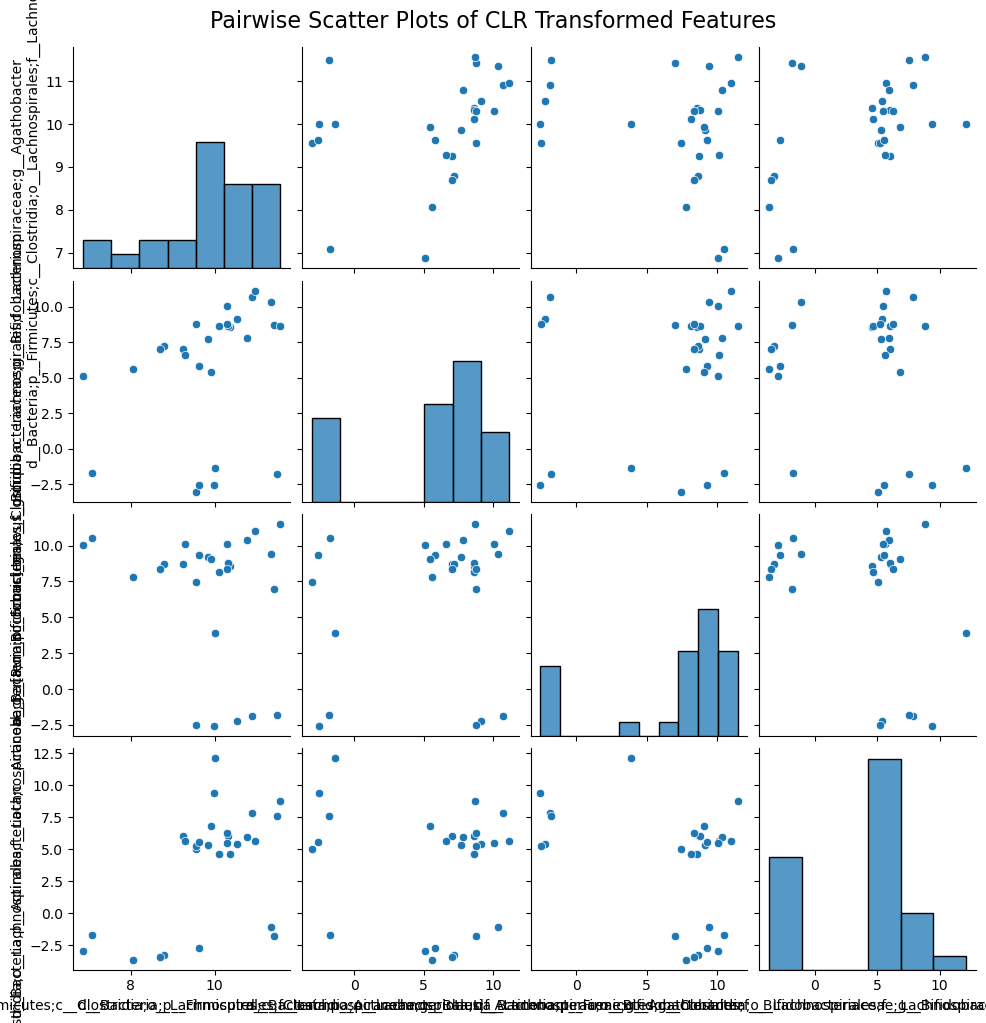

In [250]:
sns.pairplot(clr_data.iloc[:, :5])  
plt.suptitle("Pairwise Scatter Plots of CLR Transformed Features", y=1.02, fontsize=16)
plt.show()

In [255]:
# clr_data.sum(axis=1)

In [257]:
import pandas as pd

# 假设 clr_transformed_df 是 CLR 转换后的 DataFrame
output_file = "clr_transformed_data.xlsx"

# 保存为 Excel 文件
clr_data.to_excel(output_file, index=False)

print(f"CLR transformed data has been saved to '{output_file}'")

CLR transformed data has been saved to 'clr_transformed_data.xlsx'


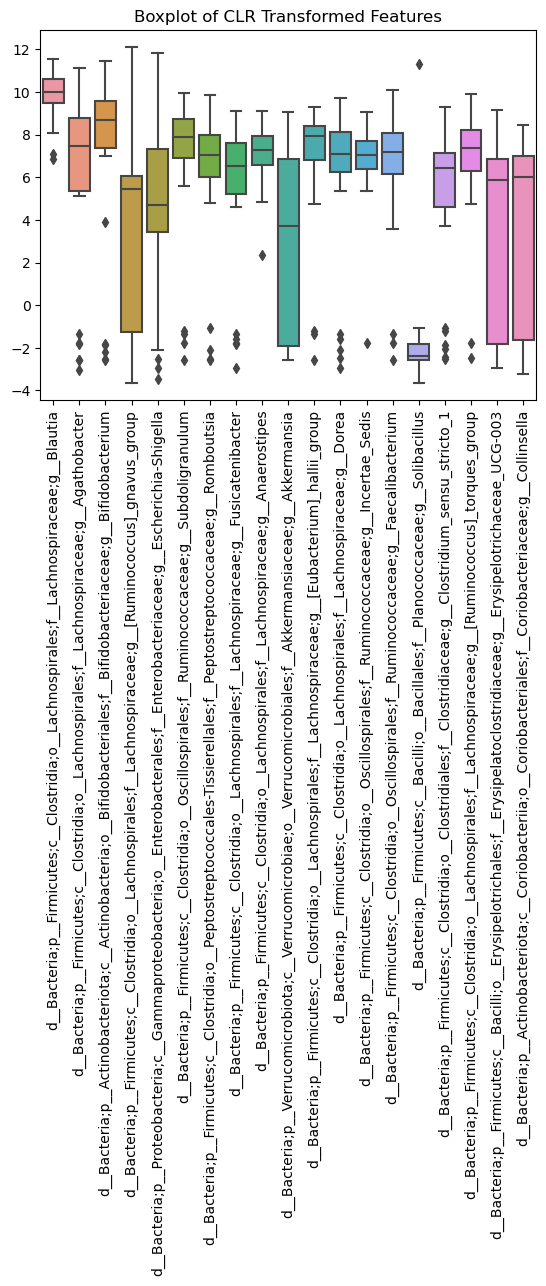

In [172]:
sns.boxplot(data=clr_data.iloc[:, 1:20])  
plt.xticks(rotation=90)
plt.title("Boxplot of CLR Transformed Features")
plt.show()

### Standardization

In [173]:
scaler = StandardScaler()
clr_standardized = scaler.fit_transform(clr_data.iloc[:,1:])
clr_standardized_df = pd.DataFrame(clr_standardized, columns=clr_data.columns[1:])
clr_standardized_df.head()

,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Blautia,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Agathobacter,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__[Ruminococcus]_gnavus_group,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia-Shigella,d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Ruminococcaceae;g__Subdoligranulum,d__Bacteria;p__Firmicutes;c__Clostridia;o__Peptostreptococcales-Tissierellales;f__Peptostreptococcaceae;g__Romboutsia,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Fusicatenibacter,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Anaerostipes,d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Akkermansiaceae;g__Akkermansia,...,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;__;__,d__Bacteria;p__Firmicutes;c__Clostridia;o__Peptostreptococcales-Tissierellales;f__Peptostreptococcaceae;g__uncultured,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Campylobacteraceae;g__Campylobacter,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__[Eubacterium]_oxidoreducens_group,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Lachnospiraceae_NC2004_group,d__Bacteria;__;__;__;__;__,d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Leuconostocaceae;g__Weissella,d__Bacteria;p__Firmicutes;c__Clostridia;o__Peptostreptococcales-Tissierellales;__;__,d__Bacteria;p__Firmicutes;c__Bacilli;__;__;__,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Planococcaceae;__
0,0.414630,0.611281,0.365630,0.161724,0.439425,0.705695,0.134476,0.643078,0.601565,-1.134379,...,-0.396242,-0.616302,-0.242923,-0.616518,-0.381133,-0.471784,-0.216337,-0.216672,-0.213383,-0.213383
1,-0.540404,0.253919,0.387961,0.481968,1.769603,0.284269,0.393197,-1.954519,-0.992493,-0.948715,...,0.209179,-0.029020,0.543239,-0.030245,0.189018,0.201226,0.509355,0.591954,0.569403,0.569403
2,0.378729,0.617165,0.407990,0.483895,-0.005300,0.452167,-0.122658,0.339825,-0.036070,1.001030,...,-0.443042,-0.661700,-0.303696,2.379054,-0.425207,-0.523809,-0.272435,-0.279180,-0.273894,-0.273894
3,0.196368,0.616670,0.261236,0.170346,-0.095640,0.560314,0.534992,0.705005,0.494488,-1.156833,...,2.871867,2.054753,-0.338000,-0.687420,-0.450086,-0.553176,-0.304101,-0.314465,-0.308052,-0.308052
4,-0.508600,0.171274,0.707815,0.393943,1.020100,0.360259,-0.345633,0.112944,1.367324,1.180660,...,-0.477817,-0.695433,-0.348852,-0.695512,-0.457956,-0.562466,-0.314118,-0.325627,-0.318857,-0.318857


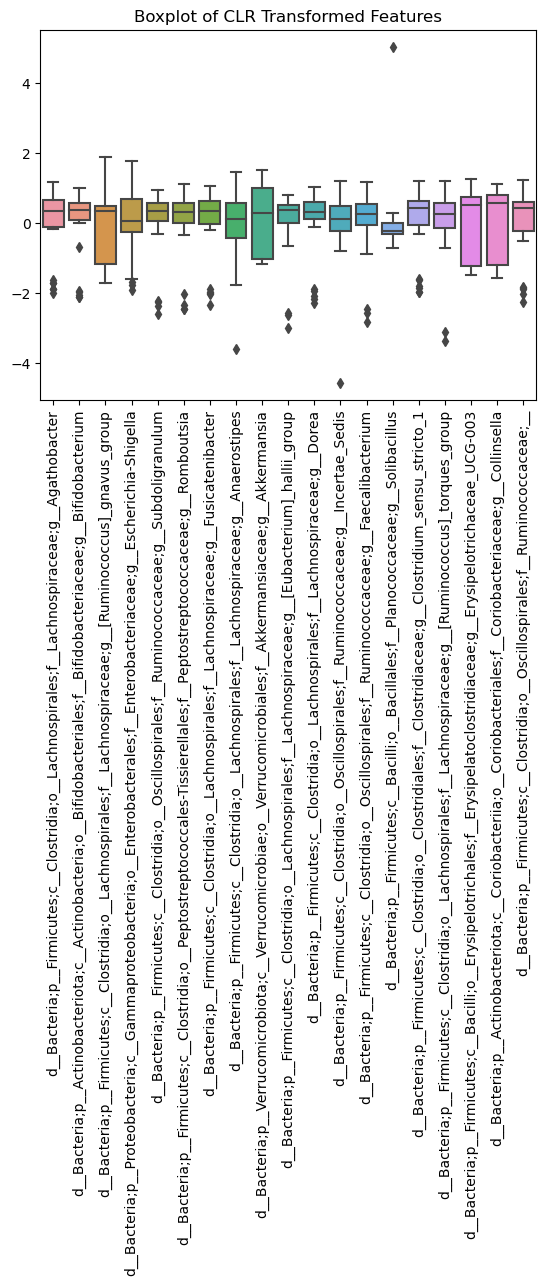

In [174]:
sns.boxplot(data=clr_standardized_df.iloc[:, 1:20])  
plt.xticks(rotation=90)
plt.title("Boxplot of CLR Transformed Features")
plt.show()

### Select top features

In [175]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.01)
filtered_features = selector.fit_transform(clr_standardized_df)

print(f"features before selection: {clr_standardized_df.shape[1]}")
print(f"features after selection: {filtered_features.shape[1]}")

features before selection: 251
features after selection: 251


### Remove High correlated features

In [176]:
correlation_matrix = pd.DataFrame(clr_standardized_df).corr().abs()
correlation_matrix

upper_corr_matrix = correlation_matrix.where(
    np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
)

upper_corr_matrix

to_drop = [column for column in upper_corr_matrix.columns if any(upper_corr_matrix[column] > 0.9)]
filtered_data = pd.DataFrame(clr_standardized_df).drop(columns=to_drop)

print(f"features before selection: {clr_standardized_df.shape[1]}")
print(f"features after selection: {filtered_data.shape[1]}")

features before selection: 251
features after selection: 210


In [177]:
print(f"features after selection: {filtered_data.shape[1]}")

features after selection: 210


In [178]:
filtered_data

,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Blautia,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Agathobacter,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__[Ruminococcus]_gnavus_group,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia-Shigella,d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Ruminococcaceae;g__Subdoligranulum,d__Bacteria;p__Firmicutes;c__Clostridia;o__Peptostreptococcales-Tissierellales;f__Peptostreptococcaceae;g__Romboutsia,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Fusicatenibacter,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Anaerostipes,d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Akkermansiaceae;g__Akkermansia,...,d__Bacteria;p__Firmicutes;c__Clostridia;o__Peptostreptococcales-Tissierellales;f__Peptostreptococcales-Tissierellales;g__Fenollaria,d__Bacteria;p__Firmicutes;__;__;__;__,d__Bacteria;p__Firmicutes;c__Clostridia;o__Peptostreptococcales-Tissierellales;f__Peptostreptococcaceae;__,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;__;__,d__Bacteria;p__Firmicutes;c__Clostridia;o__Peptostreptococcales-Tissierellales;f__Peptostreptococcaceae;g__uncultured,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Campylobacteraceae;g__Campylobacter,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__[Eubacterium]_oxidoreducens_group,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Lachnospiraceae_NC2004_group,d__Bacteria;__;__;__;__;__,d__Bacteria;p__Firmicutes;c__Clostridia;o__Peptostreptococcales-Tissierellales;__;__
0,0.414630,0.611281,0.365630,0.161724,0.439425,0.705695,0.134476,0.643078,0.601565,-1.134379,...,-0.520410,-0.449923,-0.889750,-0.396242,-0.616302,-0.242923,-0.616518,-0.381133,-0.471784,-0.216672
1,-0.540404,0.253919,0.387961,0.481968,1.769603,0.284269,0.393197,-1.954519,-0.992493,-0.948715,...,-0.027645,0.022595,-0.538319,0.209179,-0.029020,0.543239,-0.030245,0.189018,0.201226,0.591954
2,0.378729,0.617165,0.407990,0.483895,-0.005300,0.452167,-0.122658,0.339825,-0.036070,1.001030,...,-0.558502,-0.486449,-0.916917,-0.443042,-0.661700,-0.303696,2.379054,-0.425207,-0.523809,-0.279180
3,0.196368,0.616670,0.261236,0.170346,-0.095640,0.560314,0.534992,0.705005,0.494488,-1.156833,...,2.811323,-0.507068,1.486382,2.871867,2.054753,-0.338000,-0.687420,-0.450086,-0.553176,-0.314465
4,-0.508600,0.171274,0.707815,0.393943,1.020100,0.360259,-0.345633,0.112944,1.367324,1.180660,...,-0.586806,2.657007,-0.937102,-0.477817,-0.695433,-0.348852,-0.695512,-0.457956,-0.562466,-0.325627
5,0.565051,0.725803,-2.042279,0.348014,1.335617,-0.125377,0.025180,0.572162,0.084306,0.787507,...,-0.428057,-0.361365,-0.823886,-0.282775,-0.506235,-0.095583,-0.506640,-0.274277,-0.345650,-0.065121
6,0.877123,1.077895,-1.970054,0.903220,-1.531300,0.026949,0.853001,0.645960,-1.019244,-1.024327,...,-0.228323,1.969290,1.722106,-0.037379,-0.268191,0.223074,-0.269004,2.820532,-0.072857,3.923358
7,-2.388360,-1.705484,0.794308,-1.283988,1.136508,-2.364191,0.756733,-2.008057,-3.593903,0.158903,...,-0.143908,-0.088891,-0.621235,0.066335,-0.167584,0.357751,-0.168570,0.054496,0.042436,0.401167
8,-0.928316,0.297790,0.384863,-1.625135,0.033170,0.270317,0.589914,0.118294,-0.574442,0.714453,...,-1.066770,1.634716,1.060201,-1.067509,1.767000,-1.114589,-1.266553,2.134239,2.683443,-1.113244
9,0.922575,1.177831,0.908087,0.405990,0.462738,0.697936,1.113302,1.005009,0.419972,-0.878027,...,0.159967,0.202498,1.202587,0.439682,0.194577,0.842556,0.192968,0.406092,0.457463,0.899824


### Mutual information test

In [179]:
# selector = SelectKBest(score_func=mutual_info_classif, k=20)
# selected_features = selector.fit_transform(clr_standardized_df, df_target["PNS_cat"])

# print(f"Features before selection: {clr_standardized_df.shape[1]}")
# print(f"Features after selection: {selected_features.shape[1]}")

In [180]:
# selector = SelectKBest(score_func=mutual_info_classif, k=20)
# selected_features = selector.fit_transform(clr_standardized_df, df_target["Totalnum_PNS"])

# print(f"Features before selection: {clr_standardized_df.shape[1]}")
# print(f"Features after selection: {selected_features.shape[1]}")

In [181]:
# mi_scores = mutual_info_classif(clr_standardized_df, df_target[["PNS_cat"]])

mi_scores = mutual_info_classif(filtered_data, df_target[["PNS_cat"]])

mi_df = pd.DataFrame({
    "Feature": filtered_data.columns,
    "Mutual Information": mi_scores
})

mi_df = mi_df.sort_values(by="Mutual Information", ascending=False)

# mi_df[mi_df["Mutual Information"] == 0]

mi_df[mi_df["Mutual Information"] != 0].shape[0]
mi_df[mi_df["Mutual Information"] != 0]

# fi.T[mi_df["Mutual Information"] != 0].shape[1]

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


,Feature,Mutual Information
60,d__Bacteria;p__Firmicutes;c__Clostridia;o__Osc...,0.331521
130,d__Bacteria;p__Firmicutes;c__Clostridia;o__Osc...,0.240251
116,d__Bacteria;p__Firmicutes;c__Negativicutes;o__...,0.235007
46,d__Bacteria;p__Firmicutes;c__Clostridia;o__Osc...,0.228385
4,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,0.228230
...,...,...
28,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lac...,0.007839
92,d__Bacteria;p__Firmicutes;c__Clostridia;o__Eub...,0.005160
94,d__Bacteria;p__Firmicutes;c__Clostridia;o__Pep...,0.003219
27,d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...,0.002808


In [182]:
filtered_data.T

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Blautia,0.414630,-0.540404,0.378729,0.196368,-0.508600,0.565051,0.877123,-2.388360,-0.928316,0.922575,...,0.098254,-0.210069,1.443053,-0.276213,-0.214387,1.383396,0.040533,1.262932,0.107492,-1.560372
d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Agathobacter,0.611281,0.253919,0.617165,0.616670,0.171274,0.725803,1.077895,-1.705484,0.297790,1.177831,...,-1.887145,-0.011026,0.628597,0.652448,-1.889816,-1.719826,-0.098060,0.997276,-1.617683,-0.064735
d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium,0.365630,0.387961,0.407990,0.261236,0.707815,-2.042279,-1.970054,0.794308,0.384863,0.908087,...,-2.120496,0.523538,1.005243,-2.106372,0.526449,-1.953817,0.465667,0.548673,-0.679030,0.184971
d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__[Ruminococcus]_gnavus_group,0.161724,0.481968,0.483895,0.170346,0.393943,0.348014,0.903220,-1.283988,-1.625135,0.405990,...,1.257826,-1.512367,1.118710,0.312477,0.382962,0.838353,0.673698,-1.128159,1.874587,-1.713081
d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia-Shigella,0.439425,1.769603,-0.005300,-0.095640,1.020100,1.335617,-1.531300,1.136508,0.033170,0.462738,...,0.912062,-0.231744,0.531878,-1.678389,0.337609,-1.513779,0.820435,1.009756,0.261539,-0.297313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Campylobacteraceae;g__Campylobacter,-0.242923,0.543239,-0.303696,-0.338000,-0.348852,-0.095583,0.223074,0.357751,-1.114589,0.842556,...,-0.440680,-0.627902,0.888255,-0.378365,-0.452420,0.294715,3.997021,1.030284,0.743653,-1.494151
d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__[Eubacterium]_oxidoreducens_group,-0.616518,-0.030245,2.379054,-0.687420,-0.695512,-0.506640,-0.269004,-0.168570,-1.266553,0.192968,...,-0.763993,1.803401,0.227047,-0.717522,-0.772747,-0.215579,-0.782567,0.332964,0.119212,1.813424
d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Lachnospiraceae_NC2004_group,-0.381133,0.189018,-0.425207,-0.450086,-0.457956,-0.274277,2.820532,0.054496,2.134239,0.406092,...,-0.524552,-0.660332,0.439234,-0.479360,-0.533066,0.008780,-0.542617,0.542239,0.334365,-1.288564
d__Bacteria;__;__;__;__;__,-0.471784,0.201226,-0.523809,-0.553176,-0.562466,-0.345650,-0.072857,0.042436,2.683443,0.457463,...,-0.641077,2.306156,0.496584,-0.587731,-0.651127,-0.011527,-0.662400,0.618171,0.372795,2.655520


In [183]:
mi_df

,Feature,Mutual Information
60,d__Bacteria;p__Firmicutes;c__Clostridia;o__Osc...,0.331521
130,d__Bacteria;p__Firmicutes;c__Clostridia;o__Osc...,0.240251
116,d__Bacteria;p__Firmicutes;c__Negativicutes;o__...,0.235007
46,d__Bacteria;p__Firmicutes;c__Clostridia;o__Osc...,0.228385
4,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,0.228230
...,...,...
61,d__Bacteria;p__Firmicutes;c__Clostridia;o__Osc...,0.000000
50,d__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,0.000000
44,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lac...,0.000000
43,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lac...,0.000000


In [184]:
mi_df.to_excel("mi_df.xlsx",index=False)

In [185]:
# pd.merge(filtered_data, mi_df, how="inner", on=None)
zero_mi_features = mi_df[mi_df["Mutual Information"] == 0]["Feature"].tolist()
print(f"Columns with MI = 0: {zero_mi_features}")

Columns with MI = 0: ['d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Ruminococcaceae;g__Faecalibacterium', 'd__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides', 'd__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__[Ruminococcus]_gnavus_group', 'd__Bacteria;p__Firmicutes;c__Clostridia;o__Peptostreptococcales-Tissierellales;f__Peptostreptococcaceae;g__Intestinibacter', 'd__Bacteria;p__Firmicutes;c__Clostridia;o__Peptostreptococcales-Tissierellales;f__Peptostreptococcaceae;g__Romboutsia', 'd__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Fusicatenibacter', 'd__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Anaerostipes', 'd__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__[Ruminococcus]_gauvreauii_group', 'd__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__[Eubacterium]_hallii_group', 'd

In [186]:
filtered_data_cleaned = filtered_data.drop(columns=zero_mi_features, errors='ignore')
print(f"Original data shape: {filtered_data.shape}")
print(f"Cleaned data shape: {filtered_data_cleaned.shape}")

Original data shape: (28, 210)
Cleaned data shape: (28, 173)


In [187]:
filtered_data_cleaned.T.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Agathobacter,0.611281,0.253919,0.617165,0.616670,0.171274,0.725803,1.077895,-1.705484,0.297790,1.177831,...,-1.887145,-0.011026,0.628597,0.652448,-1.889816,-1.719826,-0.098060,0.997276,-1.617683,-0.064735
d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium,0.365630,0.387961,0.407990,0.261236,0.707815,-2.042279,-1.970054,0.794308,0.384863,0.908087,...,-2.120496,0.523538,1.005243,-2.106372,0.526449,-1.953817,0.465667,0.548673,-0.679030,0.184971
d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia-Shigella,0.439425,1.769603,-0.005300,-0.095640,1.020100,1.335617,-1.531300,1.136508,0.033170,0.462738,...,0.912062,-0.231744,0.531878,-1.678389,0.337609,-1.513779,0.820435,1.009756,0.261539,-0.297313
d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Ruminococcaceae;g__Subdoligranulum,0.705695,0.284269,0.452167,0.560314,0.360259,-0.125377,0.026949,-2.364191,0.270317,0.697936,...,-2.593048,0.458853,-2.212131,0.453918,0.662378,0.203925,0.701269,0.937945,-2.253578,0.138266
d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Akkermansiaceae;g__Akkermansia,-1.134379,-0.948715,1.001030,-1.156833,1.180660,0.787507,-1.024327,0.158903,0.714453,-0.878027,...,-1.181082,0.399686,-0.867235,-1.166366,1.222013,-1.007408,1.004142,1.511482,-0.901384,0.680844


### Try LDA(For target PNS_Cat)

In [188]:
n_PNS_cat_classes = df_target["PNS_cat"].nunique()
print(f"Number of classes: {n_PNS_cat_classes}")

Number of classes: 2


In [189]:
df_target["PNS_cat"].value_counts()

No     16
Yes    12
Name: PNS_cat, dtype: int64

In [190]:
filtered_features

array([[ 0.41462959,  0.61128099,  0.36562994, ..., -0.21667161,
        -0.21338313, -0.21338313],
       [-0.54040394,  0.2539185 ,  0.38796068, ...,  0.59195419,
         0.56940344,  0.56940344],
       [ 0.37872879,  0.61716489,  0.40799026, ..., -0.27918019,
        -0.27389429, -0.27389429],
       ...,
       [ 1.26293244,  0.99727592,  0.54867313, ...,  1.0929164 ,
         1.05435767,  1.05435767],
       [ 0.10749168, -1.61768347, -0.67902986, ...,  0.79809533,
         0.76895745,  0.76895745],
       [-1.56037223, -0.06473458,  0.18497071, ..., -1.5036513 ,
        -1.45923805, -1.45923805]])

In [191]:
lda = LDA(n_components=None)
reduced_data_lda = lda.fit_transform(filtered_features, df_target["PNS_cat"])
print(f"Reduced data shape with LDA: {reduced_data_lda.shape}")

Reduced data shape with LDA: (28, 1)


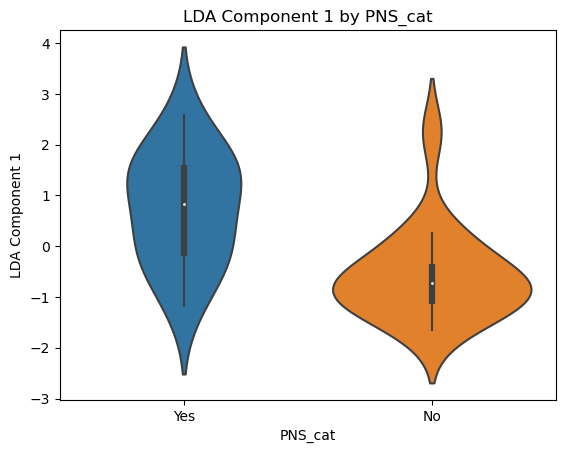

In [192]:
import seaborn as sns
import pandas as pd

lda_df = pd.DataFrame({
    "LDA Component 1": reduced_data_lda[:, 0],
    "PNS_cat": df_target["PNS_cat"]
})

sns.violinplot(x="PNS_cat", y="LDA Component 1", data=lda_df)
plt.title("LDA Component 1 by PNS_cat")
plt.show()

In [193]:
reduced_data_lda, reduced_data_lda.shape[0]

(array([[ 0.34185544],
        [ 1.49220304],
        [-1.17204415],
        [-0.62885376],
        [ 1.45425401],
        [-0.91912167],
        [-0.04944575],
        [ 2.58209459],
        [-1.34606969],
        [-0.36403601],
        [ 1.73614882],
        [ 0.25556819],
        [-0.71811793],
        [-0.73891148],
        [-1.27854833],
        [ 1.01882508],
        [-0.85537552],
        [-1.18926559],
        [-0.51881505],
        [ 0.13291289],
        [-0.40317297],
        [-0.6758146 ],
        [-0.04615924],
        [-1.64077642],
        [ 0.62982637],
        [ 2.25566632],
        [ 1.69974543],
        [-1.05457202]]),
 28)

### Baseline model

In [194]:
df_target["PNS_cat"].head()

0    Yes
1    Yes
2    Yes
3     No
4    Yes
Name: PNS_cat, dtype: object

In [195]:
df_target_copy = df_target.copy()
df_target_copy["PNS_cat"].replace({"Yes":1, "No":0}, inplace=True)
df_target_copy["PNS_cat"].head()

0    1
1    1
2    1
3    0
4    1
Name: PNS_cat, dtype: int64

#### Train test split

In [196]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(reduced_data_lda, df_target_copy["PNS_cat"], test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (22, 1)
Test set shape: (6, 1)


#### Simple RandomForest

In [197]:
model_rf = RandomForestClassifier(random_state=42)

model_rf.fit(X_train, y_train)

y_pred_rf = model_rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

Accuracy: 0.6666666666666666
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       0.50      0.50      0.50         2

    accuracy                           0.67         6
   macro avg       0.62      0.62      0.62         6
weighted avg       0.67      0.67      0.67         6



In [198]:
scores_rf = cross_val_score(model_rf, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy: {scores_rf.mean():.2f}")

Cross-validation accuracy: 0.62


<class 'shap._explanation.Explanation'>
Values: [[[-0.17863636  0.17863636]]

 [[-0.55863635  0.55863635]]

 [[ 0.36136363 -0.36136363]]

 [[ 0.43136363 -0.43136363]]

 [[ 0.34136363 -0.34136363]]

 [[ 0.43136363 -0.43136363]]]
Shape of values: (6, 1, 2)


IndexError: list index out of range

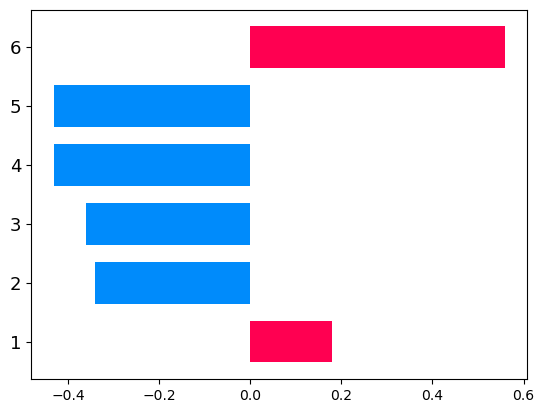

In [199]:
shap_explainer = shap.Explainer(model_rf, X_train)
shap_values = shap_explainer(X_test)
shap_values[:,:,1].shape


# shap_values_single_class = shap_values[:, :, 1]  
# shap_values.flatten()

# print("SHAP values for class 1:", shap_values_single_class)
# print("SHAP values shape:", shap_values_single_class.shape)

# import shap


# shap_values_feature = shap_values_single_class[:, 0]  


# shap.bar_plot(shap_values_feature, feature_names=["LDA Component 1"])

print(type(shap_values))  
print("Values:", shap_values.values)  
print("Shape of values:", shap_values.values.shape)  

shap_values_class_1 = shap_values.values[:, 0, 1]  


# shap.bar_plot(shap_values_class_1, feature_names=["LDA Component 1"])



### Baseline Model (Mutual information)

In [200]:
filtered_data.head()

,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Blautia,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Agathobacter,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__[Ruminococcus]_gnavus_group,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia-Shigella,d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Ruminococcaceae;g__Subdoligranulum,d__Bacteria;p__Firmicutes;c__Clostridia;o__Peptostreptococcales-Tissierellales;f__Peptostreptococcaceae;g__Romboutsia,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Fusicatenibacter,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Anaerostipes,d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Akkermansiaceae;g__Akkermansia,...,d__Bacteria;p__Firmicutes;c__Clostridia;o__Peptostreptococcales-Tissierellales;f__Peptostreptococcales-Tissierellales;g__Fenollaria,d__Bacteria;p__Firmicutes;__;__;__;__,d__Bacteria;p__Firmicutes;c__Clostridia;o__Peptostreptococcales-Tissierellales;f__Peptostreptococcaceae;__,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;__;__,d__Bacteria;p__Firmicutes;c__Clostridia;o__Peptostreptococcales-Tissierellales;f__Peptostreptococcaceae;g__uncultured,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Campylobacteraceae;g__Campylobacter,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__[Eubacterium]_oxidoreducens_group,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Lachnospiraceae_NC2004_group,d__Bacteria;__;__;__;__;__,d__Bacteria;p__Firmicutes;c__Clostridia;o__Peptostreptococcales-Tissierellales;__;__
0,0.414630,0.611281,0.365630,0.161724,0.439425,0.705695,0.134476,0.643078,0.601565,-1.134379,...,-0.520410,-0.449923,-0.889750,-0.396242,-0.616302,-0.242923,-0.616518,-0.381133,-0.471784,-0.216672
1,-0.540404,0.253919,0.387961,0.481968,1.769603,0.284269,0.393197,-1.954519,-0.992493,-0.948715,...,-0.027645,0.022595,-0.538319,0.209179,-0.029020,0.543239,-0.030245,0.189018,0.201226,0.591954
2,0.378729,0.617165,0.407990,0.483895,-0.005300,0.452167,-0.122658,0.339825,-0.036070,1.001030,...,-0.558502,-0.486449,-0.916917,-0.443042,-0.661700,-0.303696,2.379054,-0.425207,-0.523809,-0.279180
3,0.196368,0.616670,0.261236,0.170346,-0.095640,0.560314,0.534992,0.705005,0.494488,-1.156833,...,2.811323,-0.507068,1.486382,2.871867,2.054753,-0.338000,-0.687420,-0.450086,-0.553176,-0.314465
4,-0.508600,0.171274,0.707815,0.393943,1.020100,0.360259,-0.345633,0.112944,1.367324,1.180660,...,-0.586806,2.657007,-0.937102,-0.477817,-0.695433,-0.348852,-0.695512,-0.457956,-0.562466,-0.325627


In [201]:
top_features = mi_df.sort_values(by="Mutual Information", ascending=False)["Feature"].head(20).tolist()

top_features

X_top = filtered_data[top_features]

print(f"Selected top {len(top_features)} features:\n", top_features)
print(f"Shape of selected feature set: {X_top.shape}")

Selected top 20 features:
 ['d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Oscillospiraceae;g__UCG-002', 'd__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__[Clostridium]_methylpentosum_group;g__[Clostridium]_methylpentosum_group', 'd__Bacteria;p__Firmicutes;c__Negativicutes;o__Acidaminococcales;f__Acidaminococcaceae;g__Acidaminococcus', 'd__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Oscillospiraceae;g__UCG-005', 'd__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia-Shigella', 'd__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae;g__Coprobacillus', 'd__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Akkermansiaceae;g__Akkermansia', 'd__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Leuconostocaceae;g__Leuconostoc', 'd__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales-Selenomonadales;f__Veillonellaceae;g__Dial

In [202]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_top, df_target_copy["PNS_cat"], test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (22, 20)
Test set shape: (6, 20)


In [203]:
model_rf_top20 = RandomForestClassifier(random_state=42)
model_rf_top20.fit(X_train, y_train)  

y_pred = model_rf_top20.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6666666666666666
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       0.50      0.50      0.50         2

    accuracy                           0.67         6
   macro avg       0.62      0.62      0.62         6
weighted avg       0.67      0.67      0.67         6



In [204]:
logreg = LogisticRegression(random_state=42, max_iter=1000)

logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

print("Predicted values:", y_pred)

Predicted values: [1 1 0 0 0 0]


In [205]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.6667


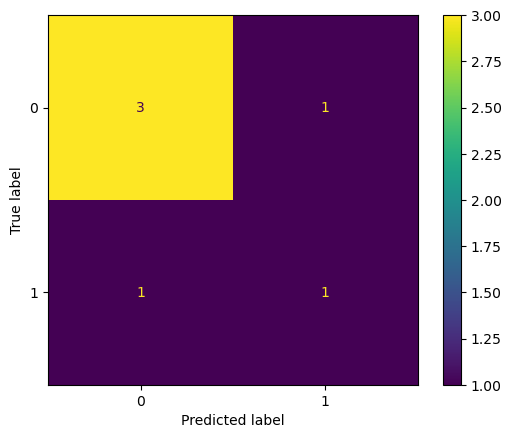

In [206]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [207]:
cv_scores = cross_val_score(logreg, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation Accuracy: {cv_scores.mean():.2f}")

Cross-validation Accuracy: 0.51


In [208]:
coef = logreg.coef_[0]

importance_df = pd.DataFrame({
    "Feature": X_top.columns,
    "Coefficient": coef
}).sort_values(by="Coefficient", ascending=False)

print(importance_df)

                                              Feature  Coefficient
4   d__Bacteria;p__Proteobacteria;c__Gammaproteoba...     1.037526
2   d__Bacteria;p__Firmicutes;c__Negativicutes;o__...     0.823017
6   d__Bacteria;p__Verrucomicrobiota;c__Verrucomic...     0.635868
15  d__Bacteria;p__Firmicutes;c__Clostridia;o__Lac...     0.608602
12                          Unassigned;__;__;__;__;__     0.597243
19  d__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...     0.354747
9   d__Bacteria;p__Firmicutes;c__Clostridia;o__Chr...     0.069478
17  d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...     0.020611
1   d__Bacteria;p__Firmicutes;c__Clostridia;o__Osc...     0.009258
11  d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...    -0.079902
13  d__Bacteria;p__Firmicutes;c__Clostridia;o__Lac...    -0.139944
18  d__Bacteria;p__Firmicutes;c__Clostridia;o__Osc...    -0.209366
0   d__Bacteria;p__Firmicutes;c__Clostridia;o__Osc...    -0.215744
7   d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...    -0.23

### Leave one out

In [209]:
# X_leave_one_out, y_leave_one_out = X_top, df_target_copy["PNS_cat"]
# X_leave_one_out.shape[0]

# logreg = LogisticRegression(random_state=42, max_iter=1000)
# loo = LeaveOneOut()
# accuries = []

# for train_index, test_index in loo.split(X_leave_one_out):
#     X_train, X_test = X_leave_one_out[train_index], X_leave_one_out[test_index]
#     y_train, y_test = y_leave_one_out[train_index], y_leave_one_out[test_index]
    
#     logreg.fit(X_train, y_train)
    
#     y_pred = logreg.predict(X_test)
    
#     accuracy = accuracy_score(y_test, y_pred)
#     accuracies.append(accuracy)

# mean_accuracy = np.mean(accuracies)
# print(f"LOOCV Mean Accuracy: {mean_accuracy:.4f}")



X_leave_one_out = X_top.values  
y_leave_one_out = df_target_copy["PNS_cat"].values  


logreg = LogisticRegression(random_state=42, max_iter=1000, penalty='l2', C=1.0)


loo = LeaveOneOut()
accuracies = []


for train_index, test_index in loo.split(X_leave_one_out):
    X_train, X_test = X_leave_one_out[train_index], X_leave_one_out[test_index]
    y_train, y_test = y_leave_one_out[train_index], y_leave_one_out[test_index]
    
    
    logreg.fit(X_train, y_train)
    
    
    y_pred = logreg.predict(X_test)
    
    
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)


mean_accuracy = np.mean(accuracies)
print(f"LOOCV Mean Accuracy: {mean_accuracy:.4f}")

LOOCV Mean Accuracy: 0.5000


In [210]:
top_features = X_top.columns.tolist() 


results = {}

for num_features in range(1, 21):
    
    selected_features = top_features[:num_features]
    X_selected = X_top[selected_features].values  
    
    
    loo = LeaveOneOut()
    accuracies = []
    
    
    for train_index, test_index in loo.split(X_selected):
        X_train, X_test = X_selected[train_index], X_selected[test_index]
        y_train, y_test = df_target_copy["PNS_cat"].values[train_index], df_target_copy["PNS_cat"].values[test_index]
        
        
        logreg = LogisticRegression(random_state=42, max_iter=1000, penalty='l2', C=1.0)
        
        
        logreg.fit(X_train, y_train)
        
        
        y_pred = logreg.predict(X_test)
        
        
        accuracies.append(accuracy_score(y_test, y_pred))
    
    
    mean_accuracy = np.mean(accuracies)
    results[num_features] = mean_accuracy
    print(f"Number of features: {num_features}, LOOCV Mean Accuracy: {mean_accuracy:.4f}")

Number of features: 1, LOOCV Mean Accuracy: 0.3571
Number of features: 2, LOOCV Mean Accuracy: 0.4286
Number of features: 3, LOOCV Mean Accuracy: 0.6786
Number of features: 4, LOOCV Mean Accuracy: 0.5000
Number of features: 5, LOOCV Mean Accuracy: 0.6071
Number of features: 6, LOOCV Mean Accuracy: 0.7500
Number of features: 7, LOOCV Mean Accuracy: 0.7500
Number of features: 8, LOOCV Mean Accuracy: 0.6786
Number of features: 9, LOOCV Mean Accuracy: 0.6071
Number of features: 10, LOOCV Mean Accuracy: 0.6071
Number of features: 11, LOOCV Mean Accuracy: 0.5714
Number of features: 12, LOOCV Mean Accuracy: 0.5714
Number of features: 13, LOOCV Mean Accuracy: 0.5357
Number of features: 14, LOOCV Mean Accuracy: 0.5357
Number of features: 15, LOOCV Mean Accuracy: 0.5714
Number of features: 16, LOOCV Mean Accuracy: 0.5000
Number of features: 17, LOOCV Mean Accuracy: 0.5357
Number of features: 18, LOOCV Mean Accuracy: 0.5357
Number of features: 19, LOOCV Mean Accuracy: 0.5000
Number of features: 2

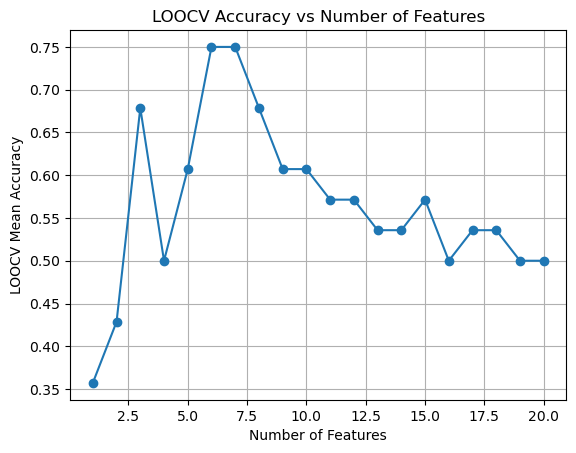

In [211]:
import matplotlib.pyplot as plt


num_features = list(results.keys())
mean_accuracies = list(results.values())


plt.plot(num_features, mean_accuracies, marker='o')
plt.xlabel("Number of Features")
plt.ylabel("LOOCV Mean Accuracy")
plt.title("LOOCV Accuracy vs Number of Features")
plt.grid(True)
plt.show()

### Try 10 - 20 features

In [212]:
top_features = mi_df.sort_values(by="Mutual Information", ascending=False)["Feature"].head(27).tolist()

top_features

X_top = filtered_data[top_features]

print(f"Selected top {len(top_features)} features:\n", top_features)
print(f"Shape of selected feature set: {X_top.shape}")

Selected top 27 features:
 ['d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Oscillospiraceae;g__UCG-002', 'd__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__[Clostridium]_methylpentosum_group;g__[Clostridium]_methylpentosum_group', 'd__Bacteria;p__Firmicutes;c__Negativicutes;o__Acidaminococcales;f__Acidaminococcaceae;g__Acidaminococcus', 'd__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Oscillospiraceae;g__UCG-005', 'd__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia-Shigella', 'd__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae;g__Coprobacillus', 'd__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Akkermansiaceae;g__Akkermansia', 'd__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Leuconostocaceae;g__Leuconostoc', 'd__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales-Selenomonadales;f__Veillonellaceae;g__Dial

In [213]:

top_features = X_top.columns.tolist()  
y_leave_one_out = df_target_copy["PNS_cat"].values  


svm_results = {}
rf_results = {}


for num_features in range(1, 27):
    
    selected_features = top_features[:num_features]
    X_selected = X_top[selected_features].values  

    
    scaler = StandardScaler()
    X_selected_scaled = scaler.fit_transform(X_selected)

    
    loo = LeaveOneOut()

    
    svm_accuracies = []
    rf_accuracies = []

    
    for train_index, test_index in loo.split(X_selected):
        X_train, X_test = X_selected[train_index], X_selected[test_index]
        X_train_scaled, X_test_scaled = X_selected_scaled[train_index], X_selected_scaled[test_index]
        y_train, y_test = y_leave_one_out[train_index], y_leave_one_out[test_index]

        
        svm = SVC(kernel='linear', random_state=42)  
        svm.fit(X_train_scaled, y_train)
        y_pred_svm = svm.predict(X_test_scaled)
        svm_accuracies.append(accuracy_score(y_test, y_pred_svm))

        
        rf = RandomForestClassifier(random_state=42)
        rf.fit(X_train, y_train)
        y_pred_rf = rf.predict(X_test)
        rf_accuracies.append(accuracy_score(y_test, y_pred_rf))

    
    svm_results[num_features] = np.mean(svm_accuracies)
    rf_results[num_features] = np.mean(rf_accuracies)
    print(f"Features: {num_features}, SVM LOOCV Accuracy: {svm_results[num_features]:.4f}, RF LOOCV Accuracy: {rf_results[num_features]:.4f}") 

Features: 1, SVM LOOCV Accuracy: 0.3571, RF LOOCV Accuracy: 0.7857
Features: 2, SVM LOOCV Accuracy: 0.3571, RF LOOCV Accuracy: 0.6786
Features: 3, SVM LOOCV Accuracy: 0.6071, RF LOOCV Accuracy: 0.6429
Features: 4, SVM LOOCV Accuracy: 0.3571, RF LOOCV Accuracy: 0.7143
Features: 5, SVM LOOCV Accuracy: 0.5714, RF LOOCV Accuracy: 0.7857
Features: 6, SVM LOOCV Accuracy: 0.7143, RF LOOCV Accuracy: 0.7500
Features: 7, SVM LOOCV Accuracy: 0.7143, RF LOOCV Accuracy: 0.8214
Features: 8, SVM LOOCV Accuracy: 0.6786, RF LOOCV Accuracy: 0.7857
Features: 9, SVM LOOCV Accuracy: 0.5357, RF LOOCV Accuracy: 0.7500
Features: 10, SVM LOOCV Accuracy: 0.6071, RF LOOCV Accuracy: 0.7857
Features: 11, SVM LOOCV Accuracy: 0.5357, RF LOOCV Accuracy: 0.7143
Features: 12, SVM LOOCV Accuracy: 0.6429, RF LOOCV Accuracy: 0.7857
Features: 13, SVM LOOCV Accuracy: 0.5357, RF LOOCV Accuracy: 0.7143
Features: 14, SVM LOOCV Accuracy: 0.5357, RF LOOCV Accuracy: 0.7500
Features: 15, SVM LOOCV Accuracy: 0.5357, RF LOOCV Accura

In [214]:
from sklearn.model_selection import LeaveOneOut
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import numpy as np


top_features = X_top.columns.tolist()  
y_leave_one_out = df_target_copy["PNS_cat"].values  


svm_results = {}
rf_results = {}
xgb_results = {}
catboost_results = {}
mlp_results = {}


for num_features in range(1, 28):

    selected_features = top_features[:num_features]
    X_selected = X_top[selected_features].values 

    scaler = StandardScaler()
    X_selected_scaled = scaler.fit_transform(X_selected)

    loo = LeaveOneOut()

    svm_accuracies = []
    rf_accuracies = []
    xgb_accuracies = []
    catboost_accuracies = []
    mlp_accuracies = []

    # LOOCV 
    for train_index, test_index in loo.split(X_selected):
        X_train, X_test = X_selected[train_index], X_selected[test_index]
        X_train_scaled, X_test_scaled = X_selected_scaled[train_index], X_selected_scaled[test_index]
        y_train, y_test = y_leave_one_out[train_index], y_leave_one_out[test_index]

        # SVM 
        svm = SVC(kernel='linear', random_state=42)
        svm.fit(X_train_scaled, y_train)
        y_pred_svm = svm.predict(X_test_scaled)
        svm_accuracies.append(accuracy_score(y_test, y_pred_svm))

        # Rf
        rf = RandomForestClassifier(random_state=42)
        rf.fit(X_train, y_train)
        y_pred_rf = rf.predict(X_test)
        rf_accuracies.append(accuracy_score(y_test, y_pred_rf))

        # XGBoost
        xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
        xgb.fit(X_train, y_train)
        y_pred_xgb = xgb.predict(X_test)
        xgb_accuracies.append(accuracy_score(y_test, y_pred_xgb))

        # CatBoost
        catboost = CatBoostClassifier(random_state=42, verbose=0)
        catboost.fit(X_train, y_train)
        y_pred_catboost = catboost.predict(X_test)
        catboost_accuracies.append(accuracy_score(y_test, y_pred_catboost))

        # MLP
        mlp = MLPClassifier(hidden_layer_sizes=(10,), max_iter=1000, random_state=42)
        mlp.fit(X_train_scaled, y_train)
        y_pred_mlp = mlp.predict(X_test_scaled)
        mlp_accuracies.append(accuracy_score(y_test, y_pred_mlp))

    # accuracy
    svm_results[num_features] = np.mean(svm_accuracies)
    rf_results[num_features] = np.mean(rf_accuracies)
    xgb_results[num_features] = np.mean(xgb_accuracies)
    catboost_results[num_features] = np.mean(catboost_accuracies)
    mlp_results[num_features] = np.mean(mlp_accuracies)

    print(
        f"Features: {num_features}, "
        f"SVM: {svm_results[num_features]:.4f}, "
        f"RF: {rf_results[num_features]:.4f}, "
        f"XGBoost: {xgb_results[num_features]:.4f}, "
        f"CatBoost: {catboost_results[num_features]:.4f}, "
        f"MLP: {mlp_results[num_features]:.4f}"
    )

Features: 1, SVM: 0.3571, RF: 0.7857, XGBoost: 0.7500, CatBoost: 0.8214, MLP: 0.5000


Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic

Features: 2, SVM: 0.3571, RF: 0.6786, XGBoost: 0.6429, CatBoost: 0.6429, MLP: 0.5714


Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic

Features: 3, SVM: 0.6071, RF: 0.6429, XGBoost: 0.6786, CatBoost: 0.6786, MLP: 0.6429


Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic

Features: 4, SVM: 0.3571, RF: 0.7143, XGBoost: 0.6429, CatBoost: 0.7143, MLP: 0.5714


Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic

Features: 5, SVM: 0.5714, RF: 0.7857, XGBoost: 0.7500, CatBoost: 0.7500, MLP: 0.6429


Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic

Features: 6, SVM: 0.7143, RF: 0.7500, XGBoost: 0.8214, CatBoost: 0.7500, MLP: 0.7500


Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic

Features: 7, SVM: 0.7143, RF: 0.8214, XGBoost: 0.8571, CatBoost: 0.7857, MLP: 0.7143


Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic

Features: 8, SVM: 0.6786, RF: 0.7857, XGBoost: 0.8214, CatBoost: 0.8214, MLP: 0.7500


Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic

Features: 9, SVM: 0.5357, RF: 0.7500, XGBoost: 0.8214, CatBoost: 0.8214, MLP: 0.6429


Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic

Features: 10, SVM: 0.6071, RF: 0.7857, XGBoost: 0.8214, CatBoost: 0.7500, MLP: 0.6429


Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.


Features: 11, SVM: 0.5357, RF: 0.7143, XGBoost: 0.8214, CatBoost: 0.7500, MLP: 0.6429


Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.


Features: 12, SVM: 0.6429, RF: 0.7857, XGBoost: 0.7857, CatBoost: 0.6786, MLP: 0.6429
Features: 13, SVM: 0.5357, RF: 0.7143, XGBoost: 0.7857, CatBoost: 0.6786, MLP: 0.6071
Features: 14, SVM: 0.5357, RF: 0.7500, XGBoost: 0.7500, CatBoost: 0.6786, MLP: 0.5000
Features: 15, SVM: 0.5357, RF: 0.7500, XGBoost: 0.7500, CatBoost: 0.7143, MLP: 0.5357
Features: 16, SVM: 0.5357, RF: 0.7500, XGBoost: 0.7500, CatBoost: 0.7143, MLP: 0.5714
Features: 17, SVM: 0.6071, RF: 0.7143, XGBoost: 0.7857, CatBoost: 0.7143, MLP: 0.5357
Features: 18, SVM: 0.6786, RF: 0.7857, XGBoost: 0.7857, CatBoost: 0.6786, MLP: 0.5000
Features: 19, SVM: 0.6429, RF: 0.7143, XGBoost: 0.7857, CatBoost: 0.6786, MLP: 0.6786
Features: 20, SVM: 0.4643, RF: 0.7500, XGBoost: 0.7857, CatBoost: 0.7143, MLP: 0.4643
Features: 21, SVM: 0.5357, RF: 0.8214, XGBoost: 0.7857, CatBoost: 0.6786, MLP: 0.4643
Features: 22, SVM: 0.6071, RF: 0.7500, XGBoost: 0.8214, CatBoost: 0.6429, MLP: 0.5714
Features: 23, SVM: 0.5714, RF: 0.7143, XGBoost: 0.8214

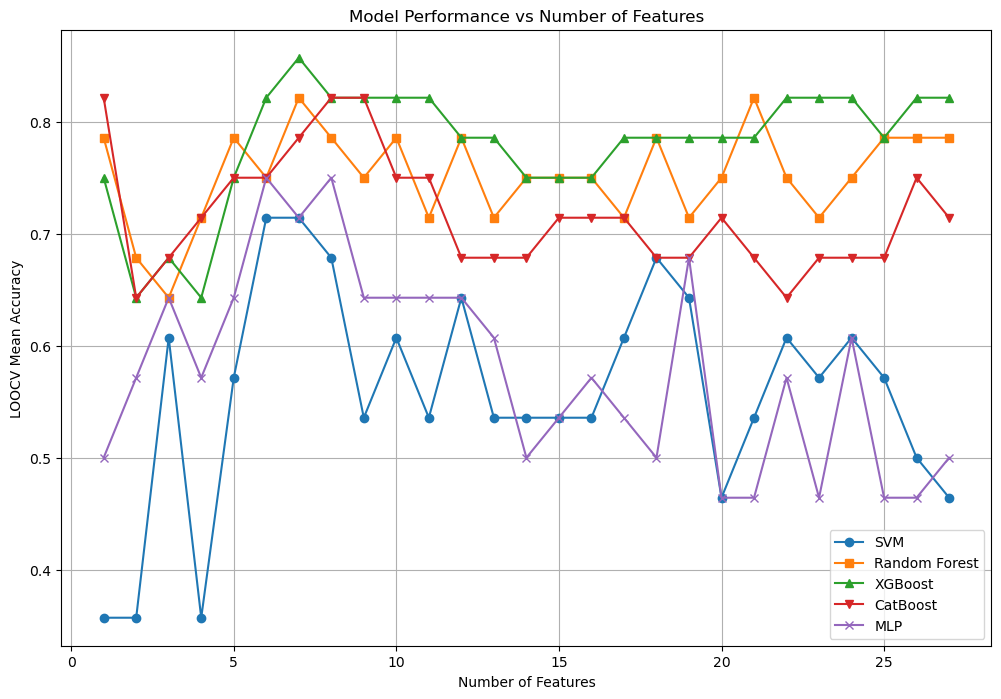

In [215]:
num_features = list(svm_results.keys())
svm_accuracies = list(svm_results.values())
rf_accuracies = list(rf_results.values())
xgb_accuracies = list(xgb_results.values())
catboost_accuracies = list(catboost_results.values())
mlp_accuracies = list(mlp_results.values())

plt.figure(figsize=(12, 8))
plt.plot(num_features, svm_accuracies, marker='o', label='SVM')
plt.plot(num_features, rf_accuracies, marker='s', label='Random Forest')
plt.plot(num_features, xgb_accuracies, marker='^', label='XGBoost')
plt.plot(num_features, catboost_accuracies, marker='v', label='CatBoost')
plt.plot(num_features, mlp_accuracies, marker='x', label='MLP')
plt.xlabel("Number of Features")
plt.ylabel("LOOCV Mean Accuracy")
plt.title("Model Performance vs Number of Features")
plt.legend()
plt.grid(True)
plt.show()

### More evaluation metrics

In [223]:
top_features = X_top.columns.tolist()  
y_leave_one_out = df_target_copy["PNS_cat"].values  


evaluation_metrics = ["accuracy", "precision", "recall", "f1"]
results = {
    "SVM": {metric: [] for metric in evaluation_metrics},
    "Random Forest": {metric: [] for metric in evaluation_metrics},
    "XGBoost": {metric: [] for metric in evaluation_metrics},
    "CatBoost": {metric: [] for metric in evaluation_metrics},
    "MLP": {metric: [] for metric in evaluation_metrics},
}


for num_features in range(1, 28):
    
    selected_features = top_features[:num_features]
    X_selected = X_top[selected_features].values  
   
    scaler = StandardScaler()
    X_selected_scaled = scaler.fit_transform(X_selected)

    loo = LeaveOneOut()

    metrics_per_model = {model: {metric: [] for metric in evaluation_metrics} for model in results.keys()}

    for train_index, test_index in loo.split(X_selected):
        X_train, X_test = X_selected[train_index], X_selected[test_index]
        X_train_scaled, X_test_scaled = X_selected_scaled[train_index], X_selected_scaled[test_index]
        y_train, y_test = y_leave_one_out[train_index], y_leave_one_out[test_index]

        models = {
            "SVM": SVC(kernel="linear", probability=True, random_state=42),
            "Random Forest": RandomForestClassifier(random_state=42),
            "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss"),
            "CatBoost": CatBoostClassifier(random_state=42, verbose=0),
            "MLP": MLPClassifier(hidden_layer_sizes=(10,), max_iter=1000, learning_rate_init=0.001, early_stopping=True, random_state=42),
        }

        for model_name, model in models.items():
            X_train_model = X_train_scaled if model_name in ["SVM", "MLP"] else X_train
            X_test_model = X_test_scaled if model_name in ["SVM", "MLP"] else X_test

            model.fit(X_train_model, y_train)
            y_pred = model.predict(X_test_model)

            if len(np.unique(y_test)) > 1:
                metrics_per_model[model_name]["recall"].append(recall_score(y_test, y_pred, zero_division=0))
                metrics_per_model[model_name]["f1"].append(f1_score(y_test, y_pred, zero_division=0))
            else:
                metrics_per_model[model_name]["recall"].append(0.0)
                metrics_per_model[model_name]["f1"].append(0.0)

            if np.sum(y_pred) > 0:
                metrics_per_model[model_name]["precision"].append(precision_score(y_test, y_pred, zero_division=0))
            else:
                metrics_per_model[model_name]["precision"].append(0.0)

            metrics_per_model[model_name]["accuracy"].append(accuracy_score(y_test, y_pred))


    for model_name in results.keys():
        for metric in evaluation_metrics:
            results[model_name][metric].append(np.mean(metrics_per_model[model_name][metric]))

    print(f"Features: {num_features}")
    for model_name in results.keys():
        print(
            f"Model: {model_name}, "
            f"Accuracy: {results[model_name]['accuracy'][-1]:.4f}, "
            f"Precision: {results[model_name]['precision'][-1]:.4f}, "
            f"Recall: {results[model_name]['recall'][-1]:.4f}, "
            f"F1: {results[model_name]['f1'][-1]:.4f}, "
        )


Features: 1
Model: SVM, Accuracy: 0.3571, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, 
Model: Random Forest, Accuracy: 0.7857, Precision: 0.3214, Recall: 0.0000, F1: 0.0000, 
Model: XGBoost, Accuracy: 0.7500, Precision: 0.2500, Recall: 0.0000, F1: 0.0000, 
Model: CatBoost, Accuracy: 0.8214, Precision: 0.3214, Recall: 0.0000, F1: 0.0000, 
Model: MLP, Accuracy: 0.5714, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, 
Features: 2
Model: SVM, Accuracy: 0.3571, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, 
Model: Random Forest, Accuracy: 0.6786, Precision: 0.2857, Recall: 0.0000, F1: 0.0000, 
Model: XGBoost, Accuracy: 0.6429, Precision: 0.2143, Recall: 0.0000, F1: 0.0000, 
Model: CatBoost, Accuracy: 0.6429, Precision: 0.2500, Recall: 0.0000, F1: 0.0000, 
Model: MLP, Accuracy: 0.7143, Precision: 0.2500, Recall: 0.0000, F1: 0.0000, 
Features: 3
Model: SVM, Accuracy: 0.6071, Precision: 0.2857, Recall: 0.0000, F1: 0.0000, 
Model: Random Forest, Accuracy: 0.6429, Precision: 0.2500, Recall: 0

Features: 21
Model: SVM, Accuracy: 0.5357, Precision: 0.2143, Recall: 0.0000, F1: 0.0000, 
Model: Random Forest, Accuracy: 0.8214, Precision: 0.2857, Recall: 0.0000, F1: 0.0000, 
Model: XGBoost, Accuracy: 0.7857, Precision: 0.3214, Recall: 0.0000, F1: 0.0000, 
Model: CatBoost, Accuracy: 0.6786, Precision: 0.2143, Recall: 0.0000, F1: 0.0000, 
Model: MLP, Accuracy: 0.4643, Precision: 0.3571, Recall: 0.0000, F1: 0.0000, 
Features: 22
Model: SVM, Accuracy: 0.6071, Precision: 0.2500, Recall: 0.0000, F1: 0.0000, 
Model: Random Forest, Accuracy: 0.7500, Precision: 0.2500, Recall: 0.0000, F1: 0.0000, 
Model: XGBoost, Accuracy: 0.8214, Precision: 0.3571, Recall: 0.0000, F1: 0.0000, 
Model: CatBoost, Accuracy: 0.6429, Precision: 0.2143, Recall: 0.0000, F1: 0.0000, 
Model: MLP, Accuracy: 0.4286, Precision: 0.3214, Recall: 0.0000, F1: 0.0000, 
Features: 23
Model: SVM, Accuracy: 0.5714, Precision: 0.2500, Recall: 0.0000, F1: 0.0000, 
Model: Random Forest, Accuracy: 0.7143, Precision: 0.2500, Recall

### Ensemble Methods + more evaluation metrics

In [228]:
# data preparation
top_features = X_top.columns.tolist()  # rank top features
y_leave_one_out = df_target_copy["PNS_cat"].values  # convert to numpy type

# initialize evaluation metrics
stacking_results = {
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1": [],
    "roc_auc": [],
    "log_loss": []
}

# number of features
total_num_features = 28

for num_features in range(1, total_num_features + 1):
    # choose top of num_features
    selected_features = top_features[:num_features]
    X_selected = X_top[selected_features].values  # extract values

    # initialize standard scaler
    scaler = StandardScaler()
    X_selected_scaled = scaler.fit_transform(X_selected)

    # initialize Leave-One-Out
    loo = LeaveOneOut()

    # initialize evaluation metrics
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    roc_aucs = []
    log_losses = []

    # stacking model
    base_models = [
        ('svm', SVC(kernel='linear', probability=True, random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('xgb', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')),
        ('catboost', CatBoostClassifier(random_state=42, verbose=0)),
        ('mlp', MLPClassifier(hidden_layer_sizes=(10,), max_iter=1000, learning_rate_init=0.001, early_stopping=True, random_state=42))
    ]
    stacking_clf = StackingClassifier(
        estimators=base_models,
        final_estimator=LogisticRegression(random_state=42),
        cv=5
    )

    # LOOCV loop
    for train_index, test_index in loo.split(X_selected_scaled):
        X_train, X_test = X_selected_scaled[train_index], X_selected_scaled[test_index]
        y_train, y_test = y_leave_one_out[train_index], y_leave_one_out[test_index]

        # training Stacking
        stacking_clf.fit(X_train, y_train)
        y_pred = stacking_clf.predict(X_test)

        # Check if `predict_proba` is supported
        if hasattr(stacking_clf, "predict_proba"):
            y_prob = stacking_clf.predict_proba(X_test)[:, 1]  # the probability of positive class
        else:
            y_prob = np.zeros_like(y_pred, dtype=float)  # default to zero probability if not supported

        # calculate metrics
        accuracies.append(accuracy_score(y_test, y_pred))
        
        # Check for valid precision/recall/F1
        if len(np.unique(y_test)) > 1:  # Ensure y_test has both classes
            precisions.append(precision_score(y_test, y_pred, zero_division=0))
            recalls.append(recall_score(y_test, y_pred, zero_division=0))
            f1_scores.append(f1_score(y_test, y_pred, zero_division=0))
        else:
            precisions.append(0.0)
            recalls.append(0.0)
            f1_scores.append(0.0)
        
        # Check for valid ROC-AUC and Log Loss
        if len(np.unique(y_test)) > 1:  # Ensure y_test has both classes
            roc_aucs.append(roc_auc_score(y_test, y_prob))
            log_losses.append(log_loss(y_test, y_prob))
        else:
            roc_aucs.append(0.0)
            log_losses.append(np.inf)  # Set log loss to infinity for invalid cases

    # average metrics
    stacking_results["accuracy"].append(np.mean(accuracies))
    stacking_results["precision"].append(np.mean(precisions))
    stacking_results["recall"].append(np.mean(recalls))
    stacking_results["f1"].append(np.mean(f1_scores))
    stacking_results["roc_auc"].append(np.mean(roc_aucs))
    stacking_results["log_loss"].append(np.mean(log_losses))

    print(f"Features: {num_features}, "
          f"Accuracy: {stacking_results['accuracy'][-1]:.4f}, "
          f"Precision: {stacking_results['precision'][-1]:.4f}, "
          f"Recall: {stacking_results['recall'][-1]:.4f}, "
          f"F1: {stacking_results['f1'][-1]:.4f}, "
          f"ROC-AUC: {stacking_results['roc_auc'][-1]:.4f}, "
          f"Log Loss: {stacking_results['log_loss'][-1]:.4f}")


Features: 1, Accuracy: 0.8214, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, ROC-AUC: 0.0000, Log Loss: inf
Features: 2, Accuracy: 0.6786, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, ROC-AUC: 0.0000, Log Loss: inf
Features: 3, Accuracy: 0.7143, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, ROC-AUC: 0.0000, Log Loss: inf
Features: 4, Accuracy: 0.7143, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, ROC-AUC: 0.0000, Log Loss: inf
Features: 5, Accuracy: 0.7500, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, ROC-AUC: 0.0000, Log Loss: inf
Features: 6, Accuracy: 0.7500, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, ROC-AUC: 0.0000, Log Loss: inf
Features: 7, Accuracy: 0.7857, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, ROC-AUC: 0.0000, Log Loss: inf
Features: 8, Accuracy: 0.7500, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, ROC-AUC: 0.0000, Log Loss: inf
Features: 9, Accuracy: 0.7500, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, ROC-AUC: 0.0000, Log Loss: inf
Features: 10, Accur

In [235]:
results

{'SVM': {'accuracy': [0.35714285714285715,
   0.35714285714285715,
   0.6071428571428571,
   0.35714285714285715,
   0.5714285714285714,
   0.7142857142857143,
   0.7142857142857143,
   0.6785714285714286,
   0.5357142857142857,
   0.6071428571428571,
   0.5357142857142857,
   0.6428571428571429,
   0.5357142857142857,
   0.5357142857142857,
   0.5357142857142857,
   0.5357142857142857,
   0.6071428571428571,
   0.6785714285714286,
   0.6428571428571429,
   0.4642857142857143,
   0.5357142857142857,
   0.6071428571428571,
   0.5714285714285714,
   0.6071428571428571,
   0.5714285714285714,
   0.5,
   0.4642857142857143],
  'precision': [0.0,
   0.0,
   0.2857142857142857,
   0.03571428571428571,
   0.2857142857142857,
   0.25,
   0.25,
   0.25,
   0.21428571428571427,
   0.25,
   0.25,
   0.25,
   0.21428571428571427,
   0.21428571428571427,
   0.21428571428571427,
   0.21428571428571427,
   0.2857142857142857,
   0.2857142857142857,
   0.2857142857142857,
   0.21428571428571427,
   0.

In [236]:
# Flatten results dictionary into a DataFrame
results_data = []

# Iterate through models and their metrics
for model_name, metrics in results.items():
    num_features = len(metrics["accuracy"])  # Number of feature counts
    for i in range(num_features):
        results_data.append({
            "Model": model_name,
            "Features": i + 1,  # Feature count starts from 1
            "Accuracy": metrics["accuracy"][i],
            "Precision": metrics["precision"][i],
            "Recall": metrics["recall"][i],
            "F1-Score": metrics["f1"][i]
        })

# Convert the flattened data into a DataFrame
results_df = pd.DataFrame(results_data)

# Save results to an Excel file
output_file = "model_results.xlsx"
results_df.to_excel(output_file, index=False)

print(f"Results saved to '{output_file}'")


Results saved to 'model_results.xlsx'


In [237]:
# Create DataFrame for stacking_results
stacking_df = pd.DataFrame({
    "Features": list(range(1, len(stacking_results["accuracy"]) + 1)),
    "Accuracy": stacking_results["accuracy"],
    "Precision": stacking_results["precision"],
    "Recall": stacking_results["recall"],
    "F1-Score": stacking_results["f1"],
    "ROC-AUC": stacking_results["roc_auc"],
    "Log Loss": stacking_results["log_loss"]
})

# Save both results to the same Excel file
with pd.ExcelWriter("combined_results.xlsx", engine="openpyxl") as writer:
    results_df.to_excel(writer, index=False, sheet_name="Model Results")
    stacking_df.to_excel(writer, index=False, sheet_name="Stacking Results")

print("Results saved to 'combined_results.xlsx'")

Results saved to 'combined_results.xlsx'


In [239]:
stacking_df.Accuracy

0     0.821429
1     0.678571
2     0.714286
3     0.714286
4     0.750000
5     0.750000
6     0.785714
7     0.750000
8     0.750000
9     0.750000
10    0.785714
11    0.714286
12    0.714286
13    0.714286
14    0.714286
15    0.714286
16    0.714286
17    0.678571
18    0.714286
19    0.714286
20    0.714286
21    0.714286
22    0.714286
23    0.678571
24    0.678571
25    0.678571
26    0.678571
27    0.678571
Name: Accuracy, dtype: float64

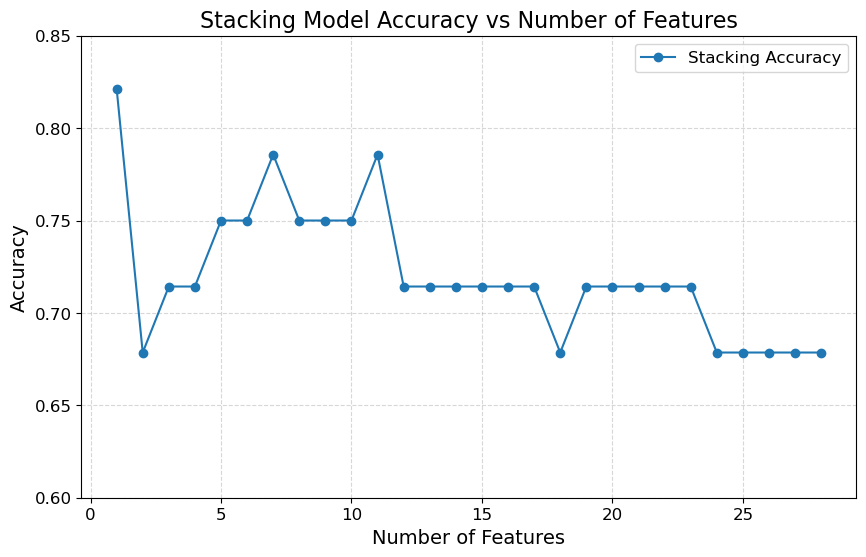

In [249]:
plt.figure(figsize=(10, 6))
plt.plot(stacking_df["Features"], stacking_df["Accuracy"], marker='o', linestyle='-', label="Stacking Accuracy")

plt.ylim(0.6,0.85)

plt.title("Stacking Model Accuracy vs Number of Features", fontsize=16)
plt.xlabel("Number of Features", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)

plt.savefig("stacking_accuracy_plot.png", dpi=300)  # 保存为图片文件
plt.show()


In [258]:
y_leave_one_out

array([1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 0])

In [263]:
X_selected_scaled

array([[-1.15997718e+00, -6.35902988e-01, -3.47721081e-01,
         2.88562340e-01,  4.39424876e-01, -3.73805434e-01,
        -1.13437904e+00, -5.00010063e-01,  9.33577592e-01,
         1.25099406e+00, -5.72666191e-01, -7.76623579e-01,
        -6.04132028e-01,  8.76941981e-01, -5.63922157e-01,
        -3.96242025e-01,  3.75208929e-01, -5.32644965e-01,
        -4.69736919e-01, -3.13889126e-01, -2.50925360e-01,
        -5.20410413e-01,  1.98147551e+00, -5.40450968e-01,
        -5.94265345e-01,  8.45957321e-01, -6.58885145e-01],
       [-9.42961071e-01, -3.41172686e-01, -2.35271070e-02,
        -1.17631337e+00,  1.76960331e+00,  3.53721093e-03,
        -9.48715246e-01, -1.62106027e-01, -7.85583007e-01,
        -1.24357354e+00, -2.19370255e-01,  1.67345709e+00,
         1.67894961e+00, -8.31547895e-01, -2.67289530e-01,
         2.09178600e-01,  6.67359026e-01, -2.31441407e-01,
        -1.27956513e-01,  2.24676260e-01,  3.53737018e-01,
        -2.76447280e-02, -1.94450849e-01, -2.47180065e-

In [266]:
X_top.to_excel("BT_training_X.xlsx", sheet_name = "BT_training_X")

In [270]:
df_target_copy["PNS_cat"].to_excel("BT_training_y.xlsx", sheet_name = "BT_training_y")